In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns


import numpy as np
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import random as rn

import re

In [5]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

##Data Collection and Dataset##

In [8]:
data = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
data.head()

,Reviews,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [9]:
data.isna().sum()

Reviews    0
Rating     0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  20491 non-null  object
 1   Rating   20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


***Class Distribution***


In [11]:
class_dist = data['Rating'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [12]:
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution in ratings')

**Most dominated Words**

In [64]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 700, height = 600,
            background_color ='Silver',
                  min_font_size = 10
             ).generate(" ".join(data.values))
    # plot the WordCloud image
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.show()

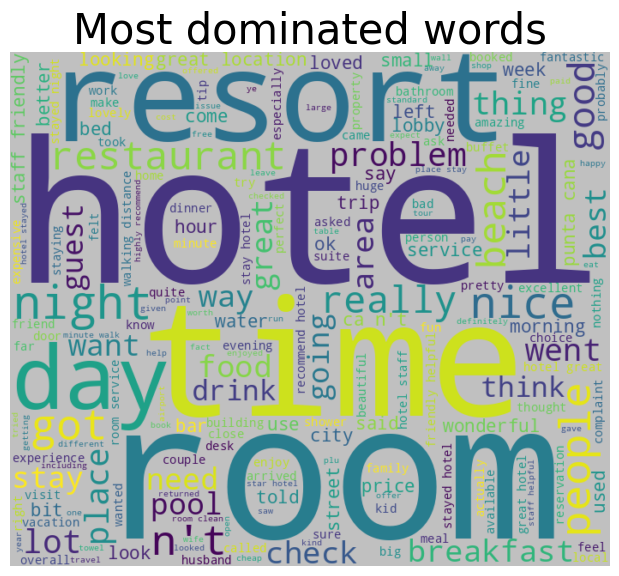

In [65]:
wordCloud_generator(data['Reviews'], title="Most dominated words")

***Data Processing***

In [27]:
X = data['Reviews'].copy()
y = data['Rating'].copy()


***Cleaning***

In [30]:
def data_cleaner(reviews):

    # remove digits
    reviews = re.sub(r'\d+',' ', reviews)

    #removing stop words
    reviews = reviews.split()
    reviews = " ".join([word for word in reviews if not word in stop_words])

    #Stemming
    #reviews = " ".join([ps.stem(w) for w in reviews])

    return reviews

ps = PorterStemmer()
stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Reviews, dtype: object

***Sentence Length distribution***

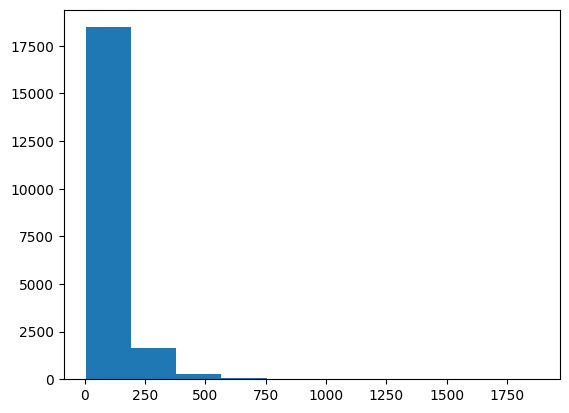

In [31]:
length_dist = [len(x.split(" ")) for x in X_cleaned]
plt.hist(length_dist)
plt.show()

***Tokenizing***

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[exp_sen]))
print("\nAfter tokenizing :\n{}".format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("\nAfter padding :\n{}".format(X[exp_sen]))

Vocabulary size: 49536
max length of sentence: 1940

Example:

Sentence:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

**Encoding**

In [34]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']

y = data['Rating'].copy()
y.replace(encoding, inplace=True)

**Split data into train/test**

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=50, stratify=y)

##Model Development##

In [40]:
EPOCHS = 5
BATCH_SIZE = 100
embedding_dim = 20
units = 80

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])


model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 20)           990720    
                                                                 
 bidirectional_2 (Bidirecti  (None, 350, 160)          64640     
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 348, 64)           30784     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 174, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 11136)             0         
                                                                 
 dropout_6 (Dropout)         (None, 11136)            

In [41]:
history = model.fit(X_train, y_train, epochs=5, validation_split=0.12, batch_size=100, verbose=2)

Epoch 1/5
163/163 - 231s - loss: 1.2410 - accuracy: 0.4431 - val_loss: 0.9342 - val_accuracy: 0.5811 - 231s/epoch - 1s/step
Epoch 2/5
163/163 - 209s - loss: 0.9184 - accuracy: 0.5774 - val_loss: 0.8500 - val_accuracy: 0.6173 - 209s/epoch - 1s/step
Epoch 3/5
163/163 - 211s - loss: 0.7424 - accuracy: 0.6711 - val_loss: 0.8749 - val_accuracy: 0.6141 - 211s/epoch - 1s/step
Epoch 4/5
163/163 - 211s - loss: 0.6143 - accuracy: 0.7416 - val_loss: 0.9568 - val_accuracy: 0.6299 - 211s/epoch - 1s/step
Epoch 5/5
163/163 - 210s - loss: 0.5005 - accuracy: 0.8032 - val_loss: 1.0641 - val_accuracy: 0.6150 - 210s/epoch - 1s/step


##Training History##

In [43]:
fig = px.line( history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

In [44]:

fig = px.line( history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

##Evaluation##

In [47]:
predictions = np.argmax(model.predict(X_test), axis=-1)

65/65 [==============================] - 20s 268ms/step


**Accuracy**

In [49]:
print('Accuracy: {}'.format(accuracy_score(predictions, y_test)))

Accuracy: 0.5921951219512195


**MAE(Mean absolute error)**

In [50]:
print("Mean absolute error: {}".format(mean_absolute_error(predictions,y_test)))

Mean absolute error: 0.4697560975609756


**RMSE(Root mean square error)**

In [51]:
print("Root mean square error: {}".format(np.sqrt(mean_squared_error(predictions,y_test))))

Root mean square error: 0.7855400503677119


##Confusion Matrix##

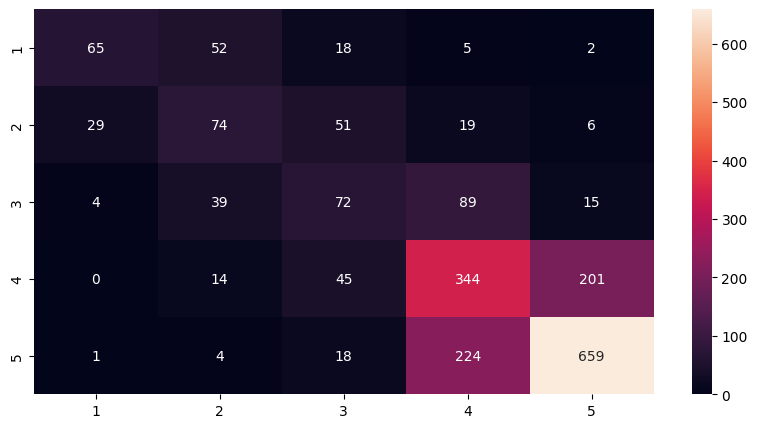

In [55]:
conf = confusion_matrix(y_test, predictions)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (10,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

##Classification Report##

In [63]:
print(classification_report(y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

           1       0.66      0.46      0.54       142
           2       0.40      0.41      0.41       179
           3       0.35      0.33      0.34       219
           4       0.51      0.57      0.54       604
           5       0.75      0.73      0.74       906

    accuracy                           0.59      2050
   macro avg       0.53      0.50      0.51      2050
weighted avg       0.60      0.59      0.59      2050

